In [21]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [40]:
import os
import re
import modin.pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import calendar

sns.set(style="whitegrid")

from Utils.UtilsViz import *
from Utils.DataUtils import *

In [23]:
print(os.listdir("./data"))

['X_test.csv', 'X_train.csv', 'sample_submission.csv', 'y_train.csv']


In [59]:
x_train = pd.read_csv("./data/X_train.csv", index_col="row_id")
y_train = pd.read_csv("./data/y_train.csv")

In [60]:
display(
    x_train.shape,
    x_train.head(),
    y_train.shape,
    y_train.head()
)

(487680, 12)

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
row_id,,,,,,,,,,,,
0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


(3810, 3)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


Join the datasets

In [78]:
x_y_train = x_train.merge(right=y_train, how="outer", on="series_id")
x_y_train.head()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


1. Cluster classes
1. Tree based approach
1. SMOTE values
1. Neural network --> statistical modelling

### How many class groups are there?

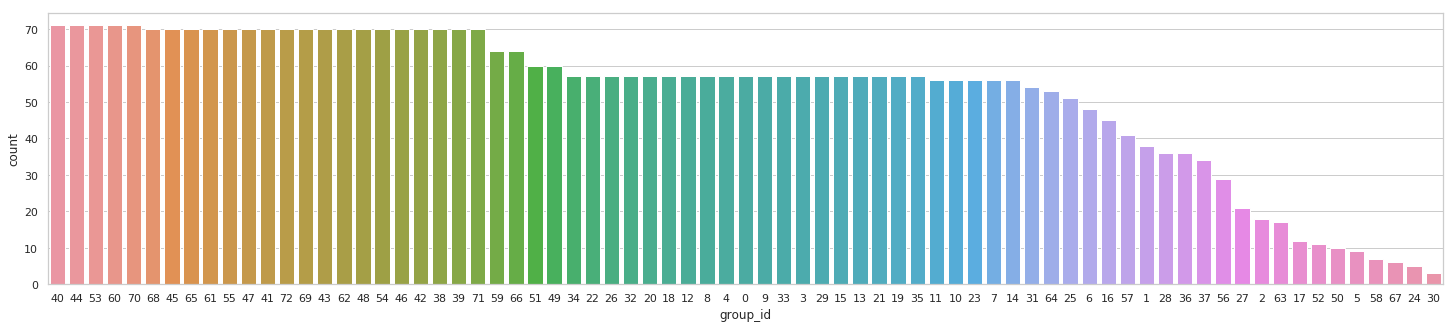

In [72]:
grp_id_vc = y_train["group_id"].value_counts()
grp_id_vc = grp_id_vc.to_frame().reset_index(drop=False)
grp_id_vc.columns = ["group_id", "count"]
grp_id_vc.sort_values(by="count", inplace=True)
f, ax = plt.subplots(1, 1, figsize=(25, 5))
g = sns.barplot(x="group_id", y="count", data=grp_id_vc, ax=ax, order=grp_id_vc["group_id"].values[::-1])

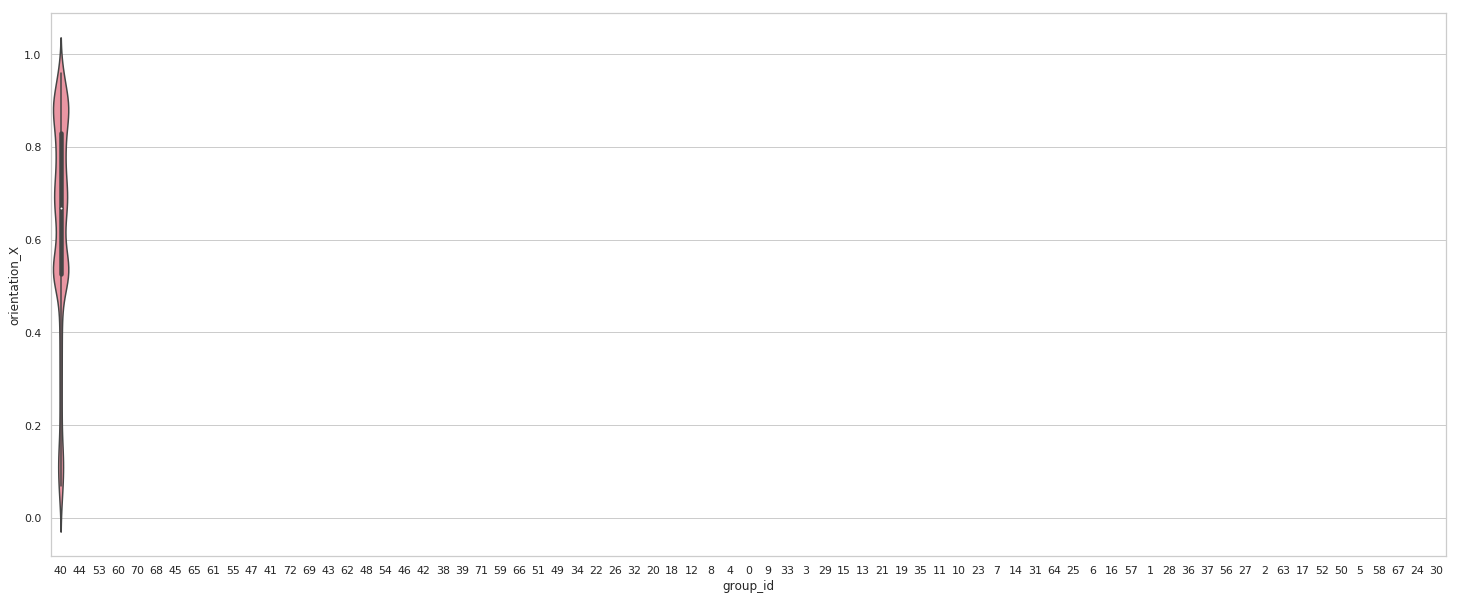

In [87]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))
g = sns.violinplot(x="group_id", y="orientation_X", data=x_y_train[x_y_train["group_id"]==40], ax=ax, order=grp_id_vc["group_id"].values[::-1])

In [55]:
orientation_cols = [x for x in x_train.columns if "orientation" in x]
angular_velocity_cols = [x for x in x_train.columns if "angular_velocity" in x]
linear_acceleration_cols = [x for x in x_train.columns if "linear_acceleration" in x]
display(
    orientation_cols,
    angular_velocity_cols,
    linear_acceleration_cols
)

['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W']

['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']

['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

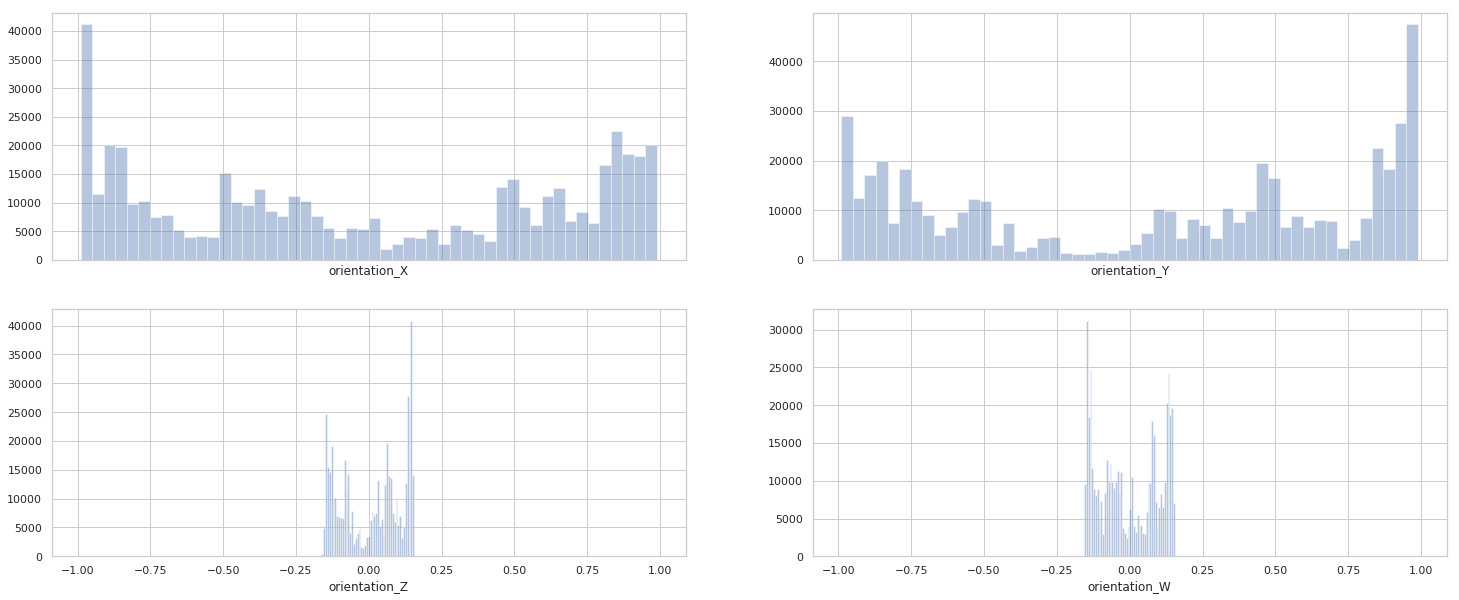

In [53]:
f, ax = plt.subplots(2, 2, figsize=(25, 10), sharex=True)
g = sns.distplot(x_train["orientation_X"], kde=False, ax=ax[0][0])
g = sns.distplot(x_train["orientation_Y"], kde=False, ax=ax[0][1])
g = sns.distplot(x_train["orientation_Z"], kde=False, ax=ax[1][0])
g = sns.distplot(x_train["orientation_W"], kde=False, ax=ax[1][1])

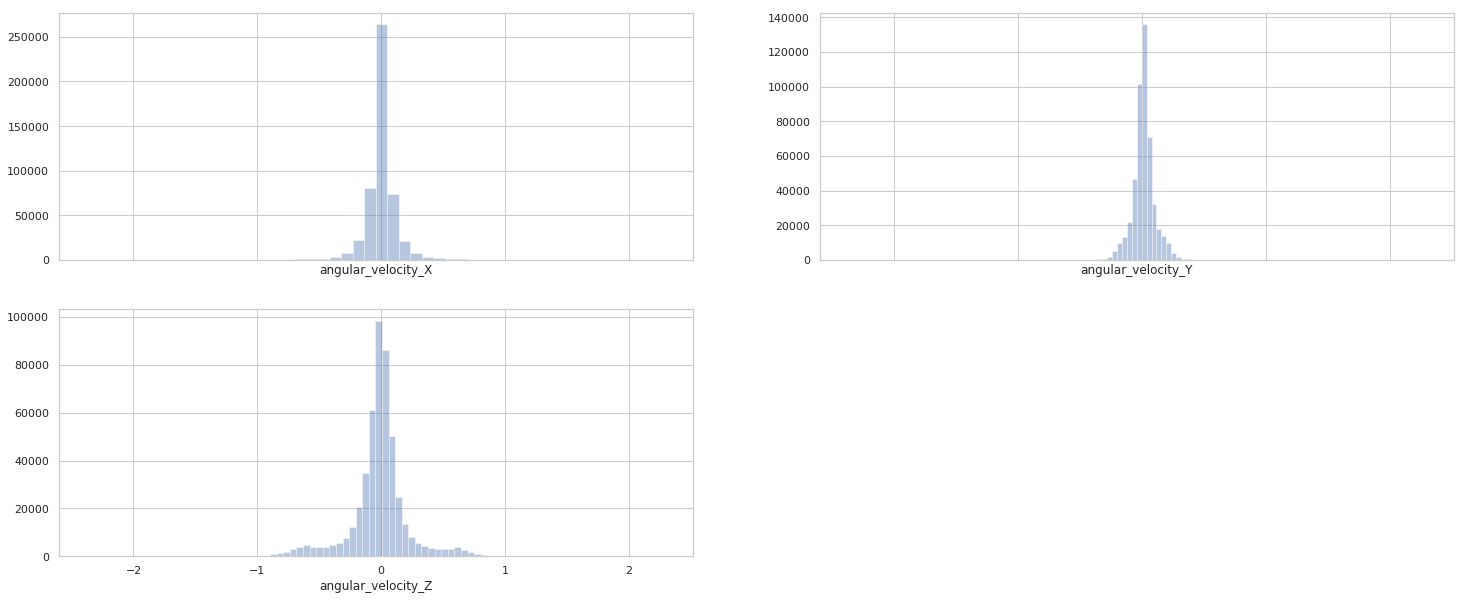

In [56]:
f, ax = plt.subplots(2, 2, figsize=(25, 10), sharex=True)
g = sns.distplot(x_train["angular_velocity_X"], kde=False, ax=ax[0][0])
g = sns.distplot(x_train["angular_velocity_Y"], kde=False, ax=ax[0][1])
g = sns.distplot(x_train["angular_velocity_Z"], kde=False, ax=ax[1][0])
v = ax=ax[1][1].set_visible(False)

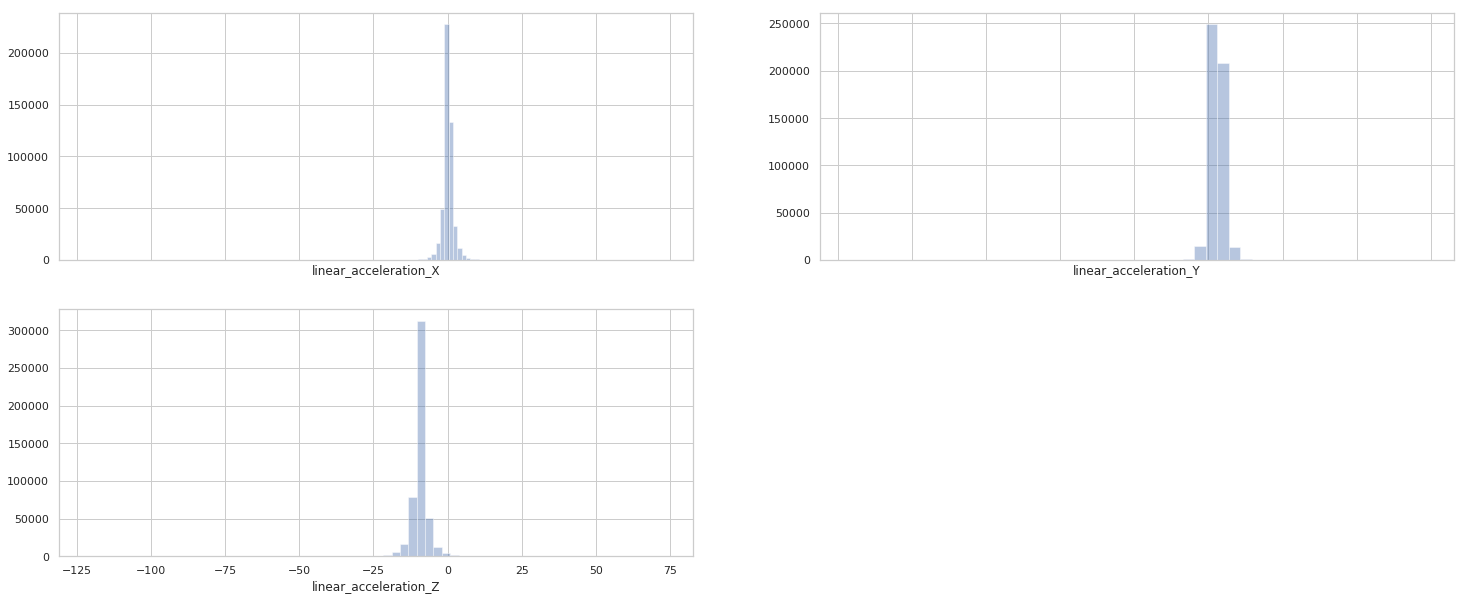

In [57]:
f, ax = plt.subplots(2, 2, figsize=(25, 10), sharex=True)
g = sns.distplot(x_train["linear_acceleration_X"], kde=False, ax=ax[0][0])
g = sns.distplot(x_train["linear_acceleration_Y"], kde=False, ax=ax[0][1])
g = sns.distplot(x_train["linear_acceleration_Z"], kde=False, ax=ax[1][0])
v = ax=ax[1][1].set_visible(False)